<a href="https://colab.research.google.com/github/ajit2704/Reinforcement-Learning-on-google-colab/blob/master/A3C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [0]:
!pip install gym

In [0]:
!apt-get install python-opengl -y

In [0]:
!apt install xvfb -y

In [0]:
!pip install pyvirtualdisplay
!pip install piglet

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
from __future__ import print_function, division
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

# Atari Environment

---



In [0]:
"""Auxilary files for those who wanted to solve breakout with CEM or policy gradient"""
import numpy as np
import gym
from scipy.misc import imresize
from gym.core import Wrapper
from gym.spaces.box import Box

class PreprocessAtari(Wrapper):
    def __init__(self, env, height=42, width=42, color=False, crop=lambda img: img, 
                 n_frames=4, dim_order='theano', reward_scale=1,):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(PreprocessAtari, self).__init__(env)
        assert dim_order in ('theano', 'tensorflow')
        self.img_size = (height, width)
        self.crop=crop
        self.color=color
        self.dim_order = dim_order
        self.reward_scale = reward_scale
        
        n_channels = (3 * n_frames) if color else n_frames
        obs_shape = [n_channels,height,width] if dim_order == 'theano' else [height,width,n_channels]
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self,action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward * self.reward_scale, done, info
    
    ### image processing ###
    
    def update_buffer(self,img):
        img = self.preproc_image(img)
        offset = 3 if self.color else 1
        if self.dim_order == 'theano':
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        else:
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

    def preproc_image(self, img):
        """what happens to the observation"""
        img = self.crop(img)
        img = imresize(img, self.img_size)
        if not self.color:
            img = img.mean(-1, keepdims=True)
        if self.dim_order == 'theano':
            img = img.transpose([2,0,1]) # [h, w, c] to [c, h, w]
        img = img.astype('float32') / 255.
        return img


In [0]:
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

In [0]:
!pip install gym
!pip install "gym[atari]"

# Deep Kung-Fu with advantage actor-critic

---

For starters, let's take a look at the game itself:

 * Image resized to 42x42 and grayscale to run faster
 * Rewards divided by 100 'cuz they are all divisible by 100
 * Agent sees last 4 frames of game to account for object velocity

In [0]:
import gym

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(env, height=42, width=42,
                          crop = lambda img: img[60:-30, 5:],
                          dim_order = 'tensorflow',
                          color=False, n_frames=4,
                          reward_scale = 0.01)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation shape: (42, 42, 4)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


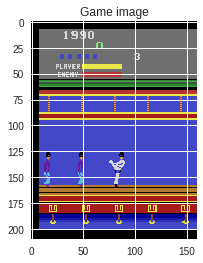

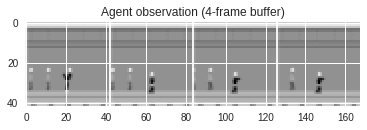

In [0]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0,2,1]).reshape([42,-1]))
plt.show()

# Build an agent

---


We now have to build an agent for actor-critic training - a convolutional neural network that converts states into action probabilities and state values .

Your assignment here is to build and apply a neural network - with any framework you want.

For starters, we want you to implement this architecture: 

After you get above 50 points, we encourage you to experiment with model architecture to score even better.

In [0]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [0]:
from keras.layers import Conv2D, Dense, Flatten, Input
import keras
from keras.models import Model, Sequential

class Agent:
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        
        with tf.variable_scope(name, reuse=reuse):
            
            # Prepare neural network architecture
            ### Your code here: prepare any necessary layers, variables, etc.
#             self.network = Sequential()
            
#             # similar architecture as the dqn
#             self.network.add(Conv2D(32, (3, 3), strides=2, activation='relu', input_shape=state_shape))
#             self.network.add(Conv2D(32, (3, 3), strides=2, activation='relu'))
#             self.network.add(Conv2D(32, (3, 3), strides=2, activation='relu'))
#             self.network.add(Flatten())
#             self.network.add(Dense(128, activation='relu'))
            
#             # logits for n_actions and 1 unit for the state value
#             self.network.add(Dense(n_actions+1, activation='linear'))


            ####
            inputs = Input(shape=state_shape)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(inputs)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x = Flatten()(x)
            x = Dense(128, activation='relu')(x)
            
            # two different output layers
            logits = Dense(n_actions, activation='linear')(x)
            state_value = Dense(1, activation='linear')(x)
            
            self.network = Model(inputs=inputs, outputs=[logits, state_value])
            
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)
        
    def symbolic_step(self, state_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        
        # Apply neural network
        ### Your code here: apply agent's neural network to get policy logits and state values.
#         network_output = self.network(state_t)

#         logits = network_output[:,1:]
#         state_value = network_output[:,0]
        
        
        logits, state_value = self.network(state_t)
        state_value = state_value[:, 0]
        
        assert tf.is_numeric_tensor(state_value) and state_value.shape.ndims == 1, \
            "please return 1D tf tensor of state values [you got %s]" % repr(state_value)
        assert tf.is_numeric_tensor(logits) and logits.shape.ndims == 2, \
            "please return 2d tf tensor of logits [you got %s]" % repr(logits)
        # hint: if you triggered state_values assert with your shape being [None, 1], 
        # just select [:, 0]-th element of state values as new state values
        
        return (logits, state_value)
    
    def step(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

Using TensorFlow backend.


In [0]:
agent = Agent("agent", obs_shape, n_actions)
sess.run(tf.global_variables_initializer())

In [0]:
state = [env.reset()]
logits, value = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


action logits:
 [[-0.04011825 -0.03369963 -0.05471736 -0.01447331 -0.03145602  0.0269252
   0.06747915 -0.00501616 -0.00702886  0.01228065 -0.05536278  0.02292078
  -0.05011498  0.01017556]]
state values:
 [0.00383585]


# Let's play!

---


Let's build a function that measures agent's average reward.

In [0]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()
        
        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done: break
                
        game_rewards.append(total_reward)
    return game_rewards


In [0]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print (rw)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In 

[3.0, 2.0, 9.0]


In [0]:
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[0])) #this may or may not be _last_ video. Try other indices


# Training on parallel games

---



![alt text](https://camo.githubusercontent.com/f894eba2ee745652f1fc95484cfa45bf26decb8e/68747470733a2f2f6769746875622e636f6d2f79616e646578646174617363686f6f6c2f50726163746963616c5f524c2f7261772f6d61737465722f7965745f616e6f746865725f7765656b2f5f7265736f757263652f2f656e765f706f6f6c2e706e67)

To make actor-critic training more stable, we shall play several games in parallel. This means ya'll have to initialize several parallel gym envs, send agent's actions there and .reset() each env if it becomes terminated. To minimize learner brain damage, we've taken care of them for ya - just make sure you read it before you use it.

In [0]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        """ Creates n_envs environments and babysits them for ya' """
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        """ Reset all games and return [n_envs, *obs_shape] observations """
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
        """
        Send a vector[batch_size] of actions into respective environments
        :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
        """
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

In [0]:
env_batch = EnvBatch(10)

batch_states = env_batch.reset()

batch_actions = agent.sample_actions(agent.step(batch_states))

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions[:3])
print("Rewards:", batch_rewards[:3])
print("Done:", batch_done[:3])


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
State shap

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


# Actor-critic

---


Here we define a loss functions and learning algorithms as usual.

In [0]:
# These placeholders mean exactly the same as in "Let's try it out" section above
states_ph = tf.placeholder('float32', [None,] + list(obs_shape))    
next_states_ph = tf.placeholder('float32', [None,] + list(obs_shape))
actions_ph = tf.placeholder('int32', (None,))
rewards_ph = tf.placeholder('float32', (None,))
is_done_ph = tf.placeholder('float32', (None,))

In [0]:
# logits[n_envs, n_actions] and state_values[n_envs, n_actions]
logits, state_values = agent.symbolic_step(states_ph)
next_logits, next_state_values = agent.symbolic_step(next_states_ph)
next_state_values = next_state_values * (1 - is_done_ph)

# probabilities and log-probabilities for all actions
probs = tf.nn.softmax(logits)            # [n_envs, n_actions]
logprobs = tf.nn.log_softmax(logits)     # [n_envs, n_actions]

# log-probabilities only for agent's chosen actions
logp_actions = tf.reduce_sum(logprobs * tf.one_hot(actions_ph, n_actions), axis=-1) # [n_envs,]

In [0]:


# compute advantage using rewards_ph, state_values and next_state_values
gamma = 0.99
advantage = rewards_ph + gamma*next_state_values - state_values

assert advantage.shape.ndims == 1, "please compute advantage for each sample, vector of shape [n_envs,]"

# compute policy entropy given logits_seq. Mind the "-" sign!
entropy =  -tf.reduce_sum(probs * logprobs, 1, name="entropy")

assert entropy.shape.ndims == 1, "please compute pointwise entropy vector of shape [n_envs,] "



actor_loss =  - tf.reduce_mean(logp_actions * tf.stop_gradient(advantage)) - 0.001 * tf.reduce_mean(entropy)

# compute target state values using temporal difference formula. Use rewards_ph and next_step_values
target_state_values = rewards_ph+gamma*next_state_values

critic_loss = tf.reduce_mean((state_values - tf.stop_gradient(target_state_values))**2 )

train_step = tf.train.AdamOptimizer(1e-4).minimize(actor_loss + critic_loss)
sess.run(tf.global_variables_initializer())

In [0]:
# Sanity checks to catch some errors. Specific to KungFuMaster in assignment's default setup.
l_act, l_crit, adv, ent = sess.run([actor_loss, critic_loss, advantage, entropy], feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    })

assert abs(l_act) < 100 and abs(l_crit) < 100, "losses seem abnormally large"
assert 0 <= ent.mean() <= np.log(n_actions), "impossible entropy value, double-check the formula pls"
if ent.mean() < np.log(n_actions) / 2: print("Entropy is too low for untrained agent")
print("You just might be fine!")

You just might be fine!


In [0]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 4.9MB/s 


# Train

---


Just the usual - play a bit, compute loss, follow the graidents, repeat a few million times.

![alt text](https://camo.githubusercontent.com/69cc1e7cffa2ebd5db67c39f7c7c2724aaf5594b/687474703a2f2f696d61676573362e66616e706f702e636f6d2f696d6167652f70686f746f732f33383930303030302f44616e69656c2d73616e2d747261696e696e672d7468652d6b61726174652d6b69642d33383934373336312d3439392d3238382e676966)



In [0]:
from IPython.display import clear_output
from tqdm import trange
from pandas import ewma
env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


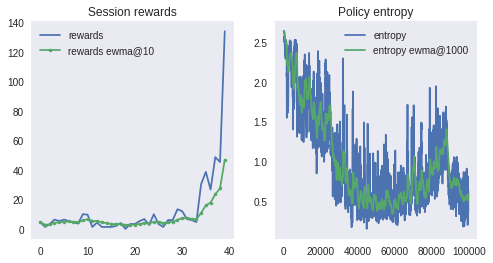

100%|██████████| 100000/100000 [59:35<00:00, 27.97it/s]


In [0]:
for i in trange(100000): 
    
    batch_actions = agent.sample_actions(agent.step(batch_states))
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
    
    feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_next_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    }
    batch_states = batch_next_states
    
    _, ent_t = sess.run([train_step, entropy], feed_dict)
    entropy_history.append(np.mean(ent_t))

    if i % 500 == 0: 
        if i % 2500 == 0:
            rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
            if rewards_history[-1] >= 50:
                print("Your agent has earned the yellow belt")

        clear_output(True)
        plt.figure(figsize=[8,4])
        plt.subplot(1,2,1)
        plt.plot(rewards_history, label='rewards')
        plt.plot(ewma(np.array(rewards_history),span=10), marker='.', label='rewards ewma@10')
        plt.title("Session rewards"); plt.grid(); plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(entropy_history, label='entropy')
        plt.plot(ewma(np.array(entropy_history),span=1000), label='entropy ewma@1000')
        plt.title("Policy entropy"); plt.grid(); plt.legend()        
        plt.show()
        
        



In [0]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=1,)
env_monitor.close()
print("Final mean reward:", np.mean(final_rewards))

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In 

Final mean reward: 72.0
